In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor

from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,classification_report

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

c:\Users\Bryan Naufal\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


# Utility

In [2]:
def plot_box(train_df, test_df):
    columns_to_plot = ['Engine Size(L)', 'Cylinders', 'Fuel Consumption City',
       'Fuel Consumption Hwy', 'Fuel Consumption Comb']

    n_rows = len(columns_to_plot) // 2  # Number of rows
    n_cols = 4  # Number of columns

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

    if n_rows == 1:
        axes = axes.reshape(1, -1)
    if n_cols == 1:
        axes = axes.reshape(-1, 1)

    for i, column in enumerate(columns_to_plot):
        row_idx = i // n_cols
        col_idx = i % n_cols
        ax = axes[row_idx, col_idx]
        boxplot = train_df.boxplot(column=[column], ax=ax)
        ax.set_title(f'Boxplot for {column}')

        # Plot lines for max and min values from test
        max_value = test_df[column].astype(int).max()
        min_value = test_df[column].astype(int).min()
        ax.axhline(max_value, color='r', linestyle='--', label=f'Max from test_df: {max_value}')
        ax.axhline(min_value, color='g', linestyle='--', label=f'Min from test_df: {min_value}')

        ax.set_title(f'Boxplot for {column}')
        ax.legend()  # Show legend

    # Remove any empty subplots
    for i in range(len(columns_to_plot), n_rows * n_cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

In [3]:
import numpy as np

def fix_fuel_consumption(column, df):
    new_fuel = []
    fuel_column = ['Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb']
    for index, row in df.iterrows():
        element = row[column]
        if type(element) != str:
            new_fuel.append(np.nan)
        elif "liters per 100 km" in element:
            if float(element.split()[0]) == 0:
                new_fuel.append(np.nan)
            else:
                new_fuel.append((100 / float(element.split()[0])))
        elif "L/100km" in element:
            if float(element.split()[0]) == 0:
                new_fuel.append(np.nan)
            else:
                new_fuel.append((100 / float(element.split()[0])))
        elif "L/100 km" in element:
            if float(element.split()[0]) == 0:
                new_fuel.append(np.nan)
            else:
                new_fuel.append((100 / float(element.split()[0])))
        elif "MPG (AS)" in element:
            # new_fuel.append(0.425143707 * float(element.split()[0]))
            new_fuel.append(float(element.split()[0])/2.352)
        elif "L/10km" in element:
            if float(element.split()[0]) == 0:
                new_fuel.append(np.nan)
            else:
                new_fuel.append((10 / float(element.split()[0])))
        elif "km/L" in element:
            new_fuel.append(float(element.split()[0]))
        elif "mpg Imp." in element:
            # new_fuel.append(1.2009 * 0.425143707 * float(element.split()[0]))
            new_fuel.append(float(element.split()[0])/2.825)
        elif "km per L" in element:
            new_fuel.append(float(element.split()[0]))
        elif element in ["-1", "0", "-9999", "9999", "zero", "not-available"]:
            new_fuel.append(np.nan)
        else:
            new_fuel.append(np.nan)
    return new_fuel


In [4]:
def fuel_fill(column, df):
    new_fuel = []
    for index, row in df.iterrows():

        if pd.isnull(row[column]):
            if column == 'Fuel Consumption City':
                hwy = row['Fuel Consumption Hwy']
                comb = row['Fuel Consumption Comb']
                if pd.isnull(hwy) or pd.isnull(comb):
                    new_fuel.append(np.nan)
                else:
                    new_fuel.append((100/55) * comb-0.45*hwy)
            elif column == 'Fuel Consumption Hwy':
                city = row['Fuel Consumption City']
                comb = row['Fuel Consumption Comb']
                if pd.isnull(city) or pd.isnull(comb):
                    new_fuel.append(np.nan)
                else:
                    new_fuel.append((100/55) * comb-0.55*city)
            elif column == 'Fuel Consumption Comb':
                city = row['Fuel Consumption City']
                hwy = row['Fuel Consumption Hwy']
                if pd.isnull(city) or pd.isnull(hwy):
                    new_fuel.append(np.nan)
                else:
                    new_fuel.append(0.55 * city + 0.45 * hwy)
        else:
            new_fuel.append(row[column])
    return new_fuel

In [5]:
transmission_null = ['not-recorded', 'unestablished', 'not-available', 'unspecified', 'unknown', '-1', 'missing']
fuel_null = ['not-recorded', 'unspecified', 'unknown', 'missing', 'not-available', 'unestablished', 'na', '-1']
general_null = transmission_null + fuel_null

# Load Data and Preprocessing

In [35]:
train_df = pd.read_csv('./data/train2.csv')
train_df.drop(['Id'], axis=1,inplace=True)
test_df = pd.read_csv('./data/test2.csv')
test_df.drop(['Id'], axis=1,inplace=True)

In [177]:
train_df.head()

Make         Vehicle Class Engine Size(L) Cylinders Transmission  \
0    MITSU           SUV - SMALL            1.5       4.0          AV8   
1   TOYOTI  PICKUP TRUCK - SMALL  not-available       6.0           A5   
2  MATSUDA               COMPACT            2.0       4.0          AS6   
3    CHEVO       VAN - PASSENGER        unknown       8.0           A6   
4   TOYOTI               COMPACT            1.8       4.0           M6   

  Fuel Type Fuel Consumption City     Fuel Consumption Hwy  \
0         X             8.40 km/L              0.72 L/10km   
1         X         7.25 km per L             9.70 L/100km   
2         X             9.80 km/L           38.70 mpg Imp.   
3         X           1.73 L/10km  11.70 liters per 100 km   
4         X          8.10 L/100km           35.76 mpg Imp.   

     Fuel Consumption Comb  CO2 Emissions(g/km)  
0              0.98 L/10km                  208  
1            11.96 L/100km                  325  
2           31.76 mpg Imp.                  170  
3  14.78 liters per 100 km                  362  
4   8.01 liters per 100 km                  180

In [160]:
test_df.head()

Make            Vehicle Class Engine Size(L)      Cylinders Transmission  \
0    FOLD  PICKUP TRUCK - STANDARD            5.0            8.0         AS10   
1     BMV                  COMPACT            2.0            4.0           A8   
2    JIPU              SUV - SMALL            1.3            4.0           A9   
3   LECUS              SUV - SMALL   not-recorded            4.0          AS6   
4  BARUSU                  COMPACT            2.0  unestablished           M6   

  Fuel Type    Fuel Consumption City     Fuel Consumption Hwy  \
0         X  14.20 liters per 100 km  15.20 liters per 100 km   
1         Z            9.10 L/100 km           43.46 mpg Imp.   
2         X           27.69 mpg Imp.   7.80 liters per 100 km   
3         Z                      NaN           26.43 MPG (AS)   
4         Z               11.36 km/L           39.79 mpg Imp.   

    Fuel Consumption Comb  
0          16.06 MPG (AS)  
1          29.66 MPG (AS)  
2  9.12 liters per 100 km  
3                     NaN  
4            8.04 L/100km

## Cleaning
detect all missing value

change fuel consumption into KM/L and fill the missing based on another Fuel Consumption

In [36]:
new_vc = []
for element in train_df['Vehicle Class']:
    if element in general_null:
        new_vc.append(np.nan)
    else:
        new_vc.append(element)
train_df['Vehicle Class'] = new_vc

new_fuel = []
for element in train_df['Fuel Type']:
    if element in fuel_null:
        new_fuel.append(np.nan)
    else:
        new_fuel.append(element)
train_df['Fuel Type'] = new_fuel

new_transmission = []
for element in train_df['Transmission']:
    if element in transmission_null:
        new_transmission.append(np.nan)
    else:
        new_transmission.append(element)
train_df['Transmission'] = new_transmission

new_cylinders = []
for element in train_df['Cylinders']:
    if element in general_null:
        new_cylinders.append(np.nan)
    else:
        new_cylinders.append(element)
train_df['Cylinders'] = new_cylinders

new_engine = []
for element in train_df['Engine Size(L)']:
    if element in general_null:
        new_engine.append(np.nan)
    else:
        new_engine.append(element)
train_df['Engine Size(L)'] = new_engine

new_fuel_city = fix_fuel_consumption("Fuel Consumption City", train_df)
train_df['Fuel Consumption City'] = new_fuel_city
new_fuel_hwy = fix_fuel_consumption("Fuel Consumption Hwy", train_df)
train_df['Fuel Consumption Hwy'] = new_fuel_hwy
new_fuel_comb = fix_fuel_consumption("Fuel Consumption Comb", train_df)
train_df['Fuel Consumption Comb'] = new_fuel_comb

# new_fuel_city = fuel_fill("Fuel Consumption City", train_df)
# train_df['Fuel Consumption City'] = new_fuel_city
# new_fuel_hwy = fuel_fill("Fuel Consumption Hwy", train_df)
# train_df['Fuel Consumption Hwy'] = new_fuel_hwy
# new_fuel_comb = fuel_fill("Fuel Consumption Comb", train_df)
# train_df['Fuel Consumption Comb'] = new_fuel_comb

train_df['Cylinders'] = train_df['Cylinders'].astype(float)
train_df['Engine Size(L)'] = train_df['Engine Size(L)'].astype(float)

In [9]:
clean_df = train_df.dropna()

In [12]:
clean_df.shape

(37019, 10)

In [37]:
new_vc = []
for element in test_df['Vehicle Class']:
    if element in general_null:
        new_vc.append(np.nan)
    else:
        new_vc.append(element)
test_df['Vehicle Class'] = new_vc

new_fuel = []
for element in test_df['Fuel Type']:
    if element in fuel_null:
        new_fuel.append(np.nan)
    else:
        new_fuel.append(element)
test_df['Fuel Type'] = new_fuel

new_transmission = []
for element in test_df['Transmission']:
    if element in transmission_null:
        new_transmission.append(np.nan)
    else:
        new_transmission.append(element)
test_df['Transmission'] = new_transmission

new_cylinders = []
for element in test_df['Cylinders']:
    if element in general_null:
        new_cylinders.append(np.nan)
    else:
        new_cylinders.append(element)
test_df['Cylinders'] = new_cylinders

new_engine = []
for element in test_df['Engine Size(L)']:
    if element in general_null:
        new_engine.append(np.nan)
    else:
        new_engine.append(element)
test_df['Engine Size(L)'] = new_engine

new_fuel_city = fix_fuel_consumption("Fuel Consumption City", test_df)
test_df['Fuel Consumption City'] = new_fuel_city
new_fuel_hwy = fix_fuel_consumption("Fuel Consumption Hwy", test_df)
test_df['Fuel Consumption Hwy'] = new_fuel_hwy
new_fuel_comb = fix_fuel_consumption("Fuel Consumption Comb", test_df)
test_df['Fuel Consumption Comb'] = new_fuel_comb

# new_fuel_city = fuel_fill("Fuel Consumption City", test_df)
# test_df['Fuel Consumption City'] = new_fuel_city
# new_fuel_hwy = fuel_fill("Fuel Consumption Hwy", test_df)
# test_df['Fuel Consumption Hwy'] = new_fuel_hwy
# new_fuel_comb = fuel_fill("Fuel Consumption Comb", test_df)
# test_df['Fuel Consumption Comb'] = new_fuel_comb

test_df['Cylinders'] = test_df['Cylinders'].astype(float)
test_df['Engine Size(L)'] = test_df['Engine Size(L)'].astype(float)


## Check Missing Value

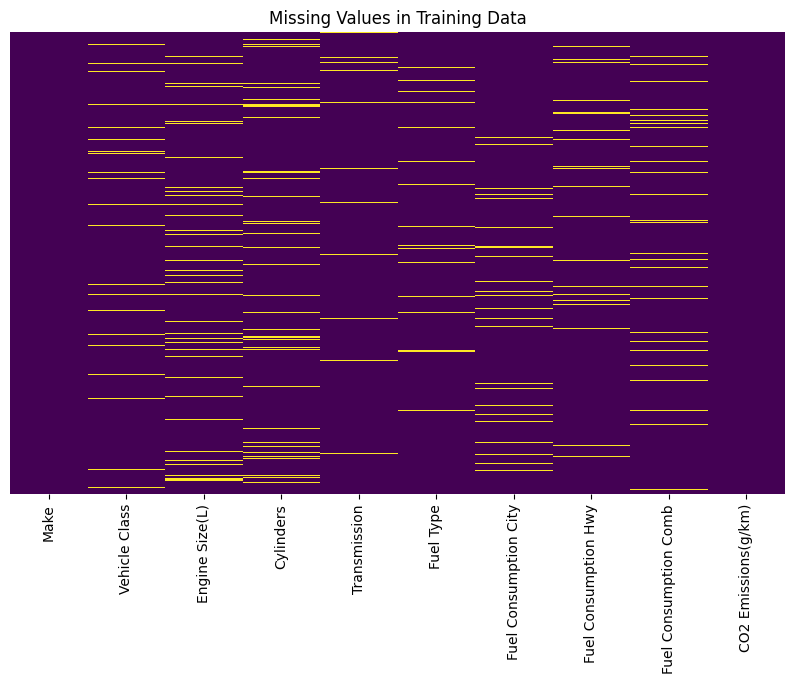

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check for missing values
missing_values = train_df.isnull().sum()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Missing Values in Training Data')
plt.show()

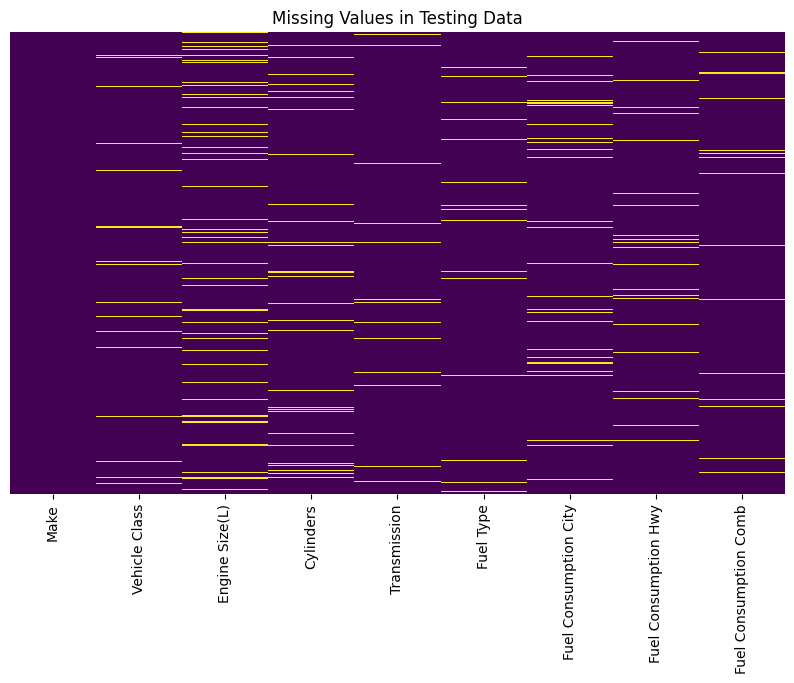

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check for missing values
missing_values = test_df.isnull().sum()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(test_df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Missing Values in Testing Data')
plt.show()

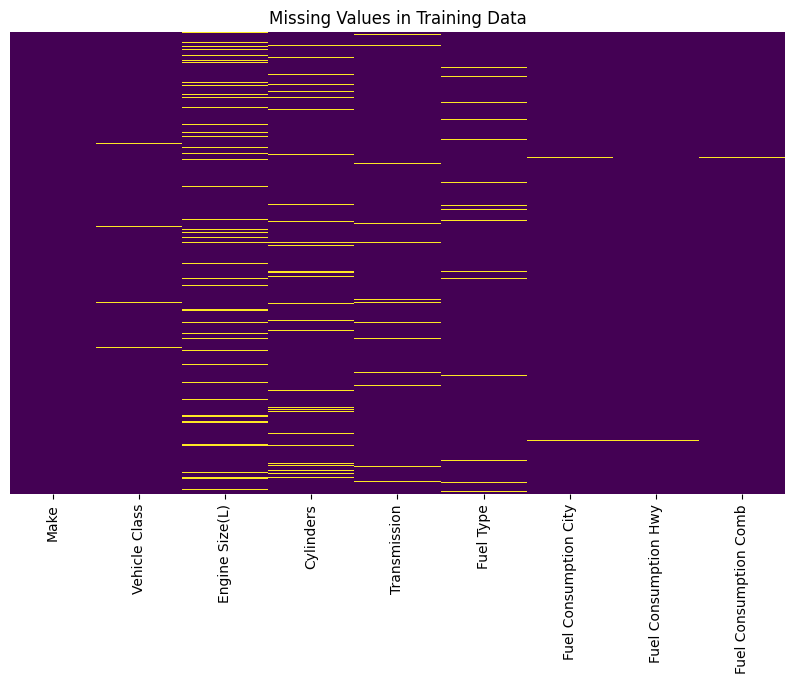

In [91]:
# Check for missing values
missing_values = test_df.isnull().sum()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(test_df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Missing Values in Training Data')
plt.show()


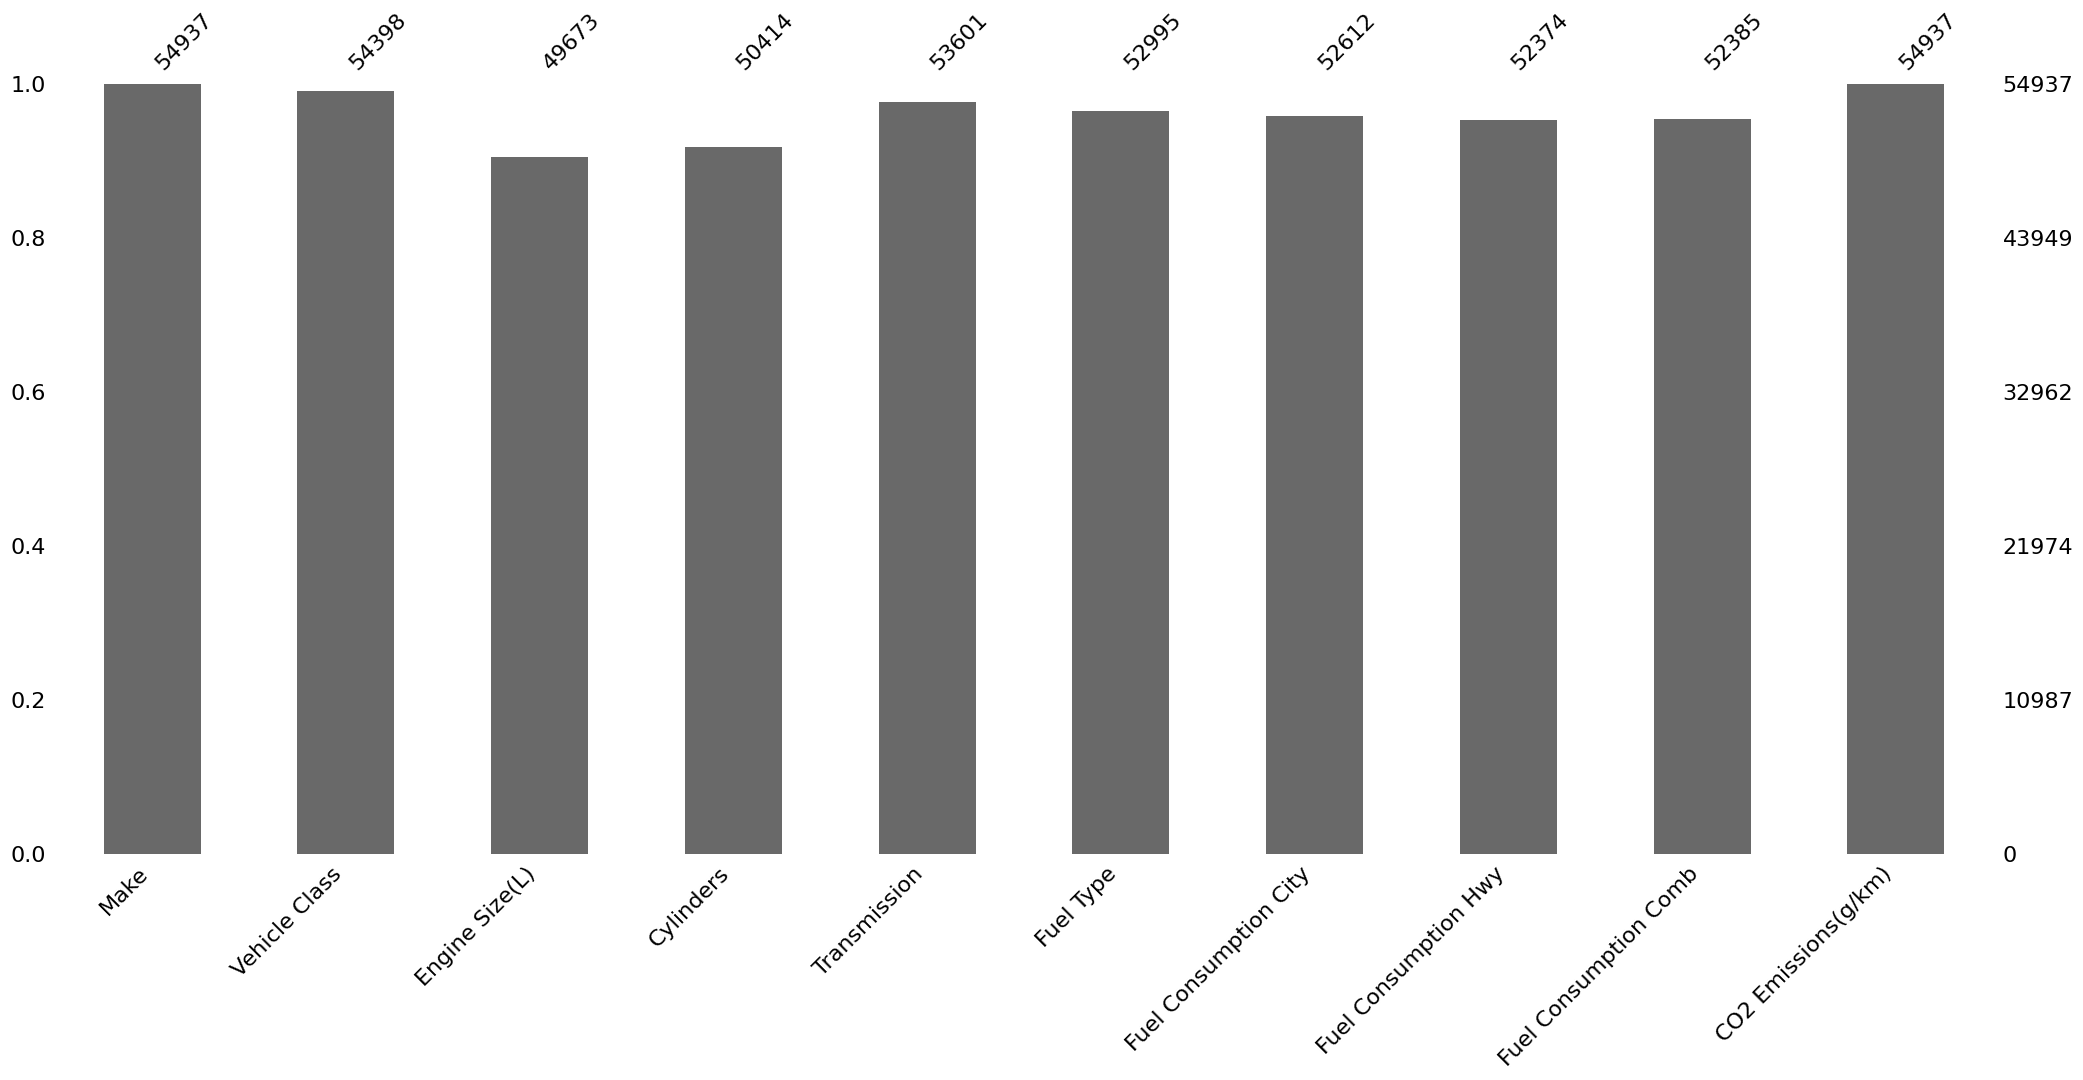

In [18]:
import missingno as msno
import matplotlib.pyplot as plt

# Assuming train_df is your training DataFrame
# msno.matrix(train_df)
# plt.show()

msno.bar(train_df)
plt.show()

Missing Value pada kolum Fuel Consumption tersisa yang dua dari tiga Fuel Consumption missing sehingga akan digunakan KNN Imputer nanti
Missing Value pada kolum lain akan digunakan KNN Imputer. Penggunaan Machine Learning dalam melakukan imputasi setidaknya dapat memberikan nilai yang lebih sesuai ketimbang simple imputasi

In [92]:
def create_feature(df):
  df_copy = df.copy()
  return df_copy

ready_df = create_feature(train_df)

# Explorartory Data Analysis

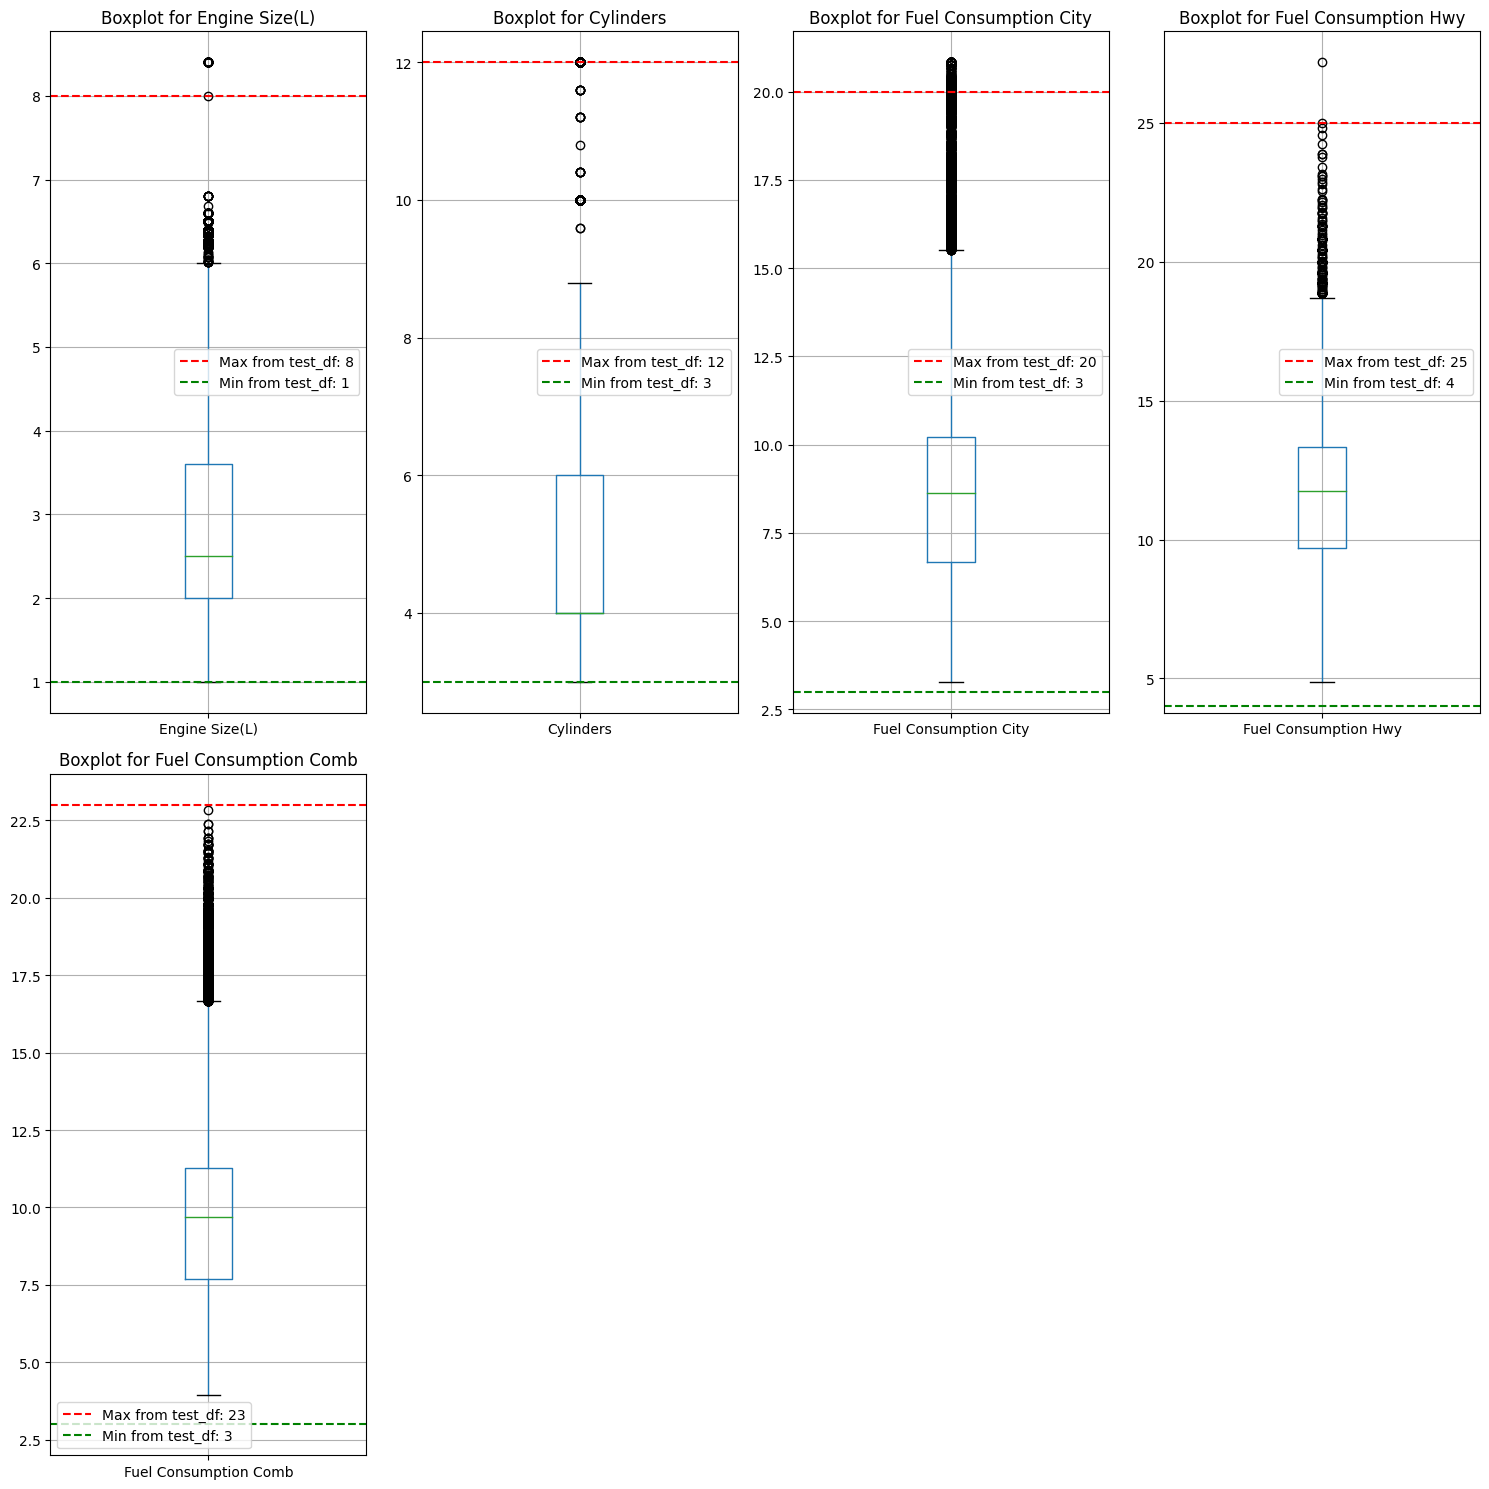

In [72]:
plot_box(ready_df, test_df)

In [19]:
clean_df

Make            Vehicle Class  Engine Size(L)  Cylinders  \
0        MITSU              SUV - SMALL             1.5        4.0   
2      MATSUDA                  COMPACT             2.0        4.0   
4       TOYOTI                  COMPACT             1.8        4.0   
5         DOGE                 MID-SIZE             2.4        4.0   
7        LECUS                 MID-SIZE             3.5        6.0   
...        ...                      ...             ...        ...   
54931      KIO    STATION WAGON - SMALL             1.6        4.0   
54932    CHEVO               SUBCOMPACT             6.2        8.0   
54933    CHEVO               SUBCOMPACT             3.6        6.0   
54934     FOLD               TWO-SEATER             3.5        6.0   
54935    CHEVO  PICKUP TRUCK - STANDARD             6.2        8.0   

      Transmission Fuel Type  Fuel Consumption City  Fuel Consumption Hwy  \
0              AV8         X               8.400000             13.888889   
2              AS6         X               9.800000             13.699115   
4               M6         X              12.345679             12.658407   
5               A6         X               8.850000             12.500000   
7              AS6         X               8.333333             10.100000   
...            ...       ...                    ...                   ...   
54931           M6         X              10.637755             12.820513   
54932         AS10         Z               8.403361             11.360000   
54933           M6         X               4.761905              9.433962   
54934          AM7         Z               5.494505              8.000000   
54935           A8         Z               5.464481             10.101010   

       Fuel Consumption Comb  CO2 Emissions(g/km)  
0                  10.204082                  208  
2                  11.242478                  170  
4                  12.484395                  180  
5                  10.193680                  216  
7                   9.047619                  221  
...                      ...                  ...  
54931              11.520000                  202  
54932               9.519558                  318  
54933               6.126701                  303  
54934               6.397953                  410  
54935               6.887052                  466  

[37019 rows x 10 columns]

Dapat terlihat, value yang terdapat pada data train mempunyai nilai yang masih dalam range data test

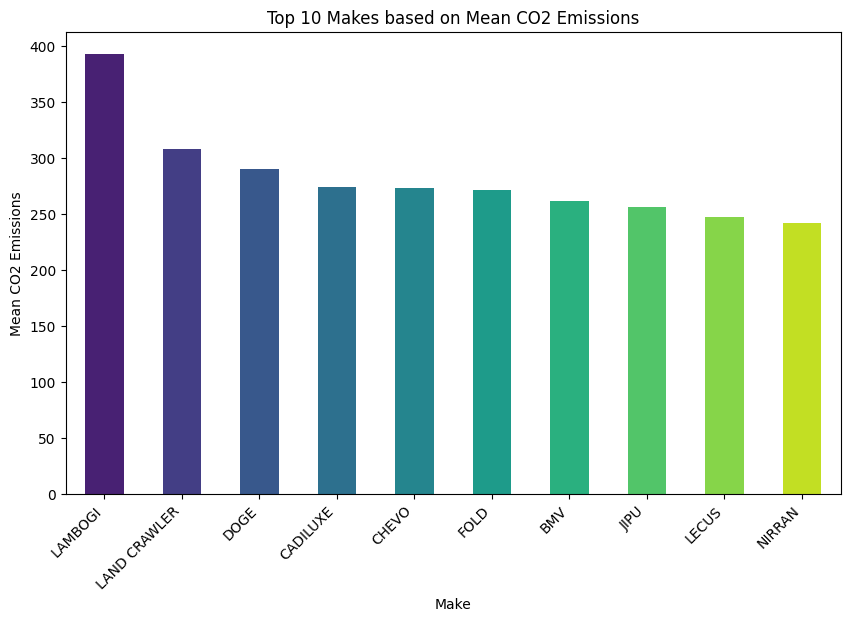

In [22]:
import seaborn as sns  # Importing seaborn for colormaps

# Assuming df is your DataFrame
top_make_by_co2 = train_df.groupby('Make')['CO2 Emissions(g/km)'].mean().sort_values(ascending=False).head(10)

# Plotting the top 10 'Make' values based on mean 'CO2' emissions with a gradient color
plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", len(top_make_by_co2))  # Choose a colormap, e.g., "viridis"
top_make_by_co2.plot(kind='bar', color=colors)
plt.title('Top 10 Makes based on Mean CO2 Emissions')
plt.xlabel('Make')
plt.ylabel('Mean CO2 Emissions')
plt.xticks(rotation=45, ha='right')
plt.show()


LAMBOGI, LAND CRAWLER, DOGE, CADILUXE, CHEVO

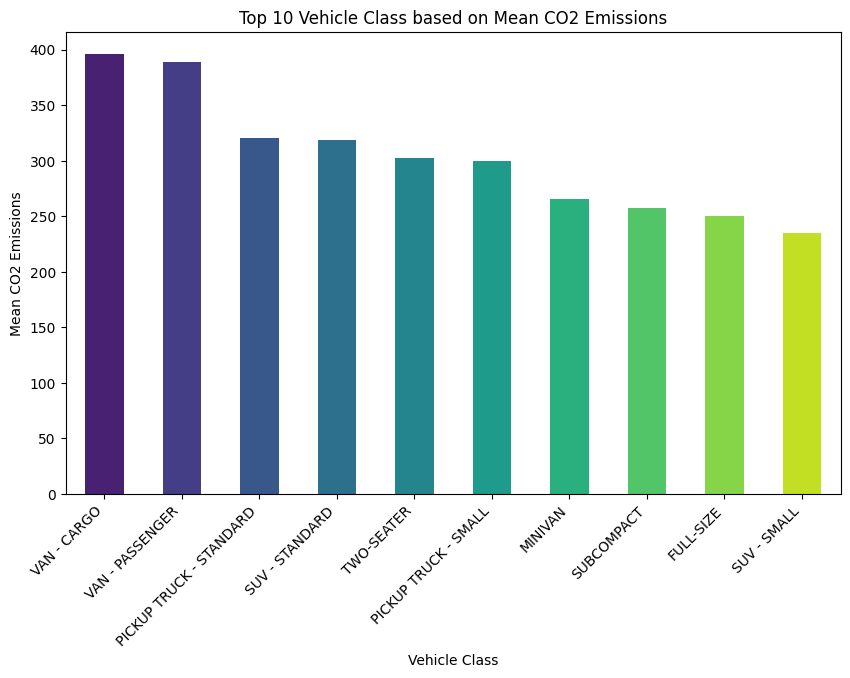

In [40]:
import seaborn as sns  # Importing seaborn for colormaps

# Assuming df is your DataFrame
top_make_by_co2 = train_df.groupby('Vehicle Class')['CO2 Emissions(g/km)'].mean().sort_values(ascending=False).head(10)

# Plotting the top 10 'Vehicle Class' values based on mean 'CO2' emissions with a gradient color
plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", len(top_make_by_co2))  # Choose a colormap, e.g., "viridis"
top_make_by_co2.plot(kind='bar', color=colors)
plt.title('Top 10 Vehicle Class based on Mean CO2 Emissions')
plt.xlabel('Vehicle Class')
plt.ylabel('Mean CO2 Emissions')
plt.xticks(rotation=45, ha='right')
plt.show()


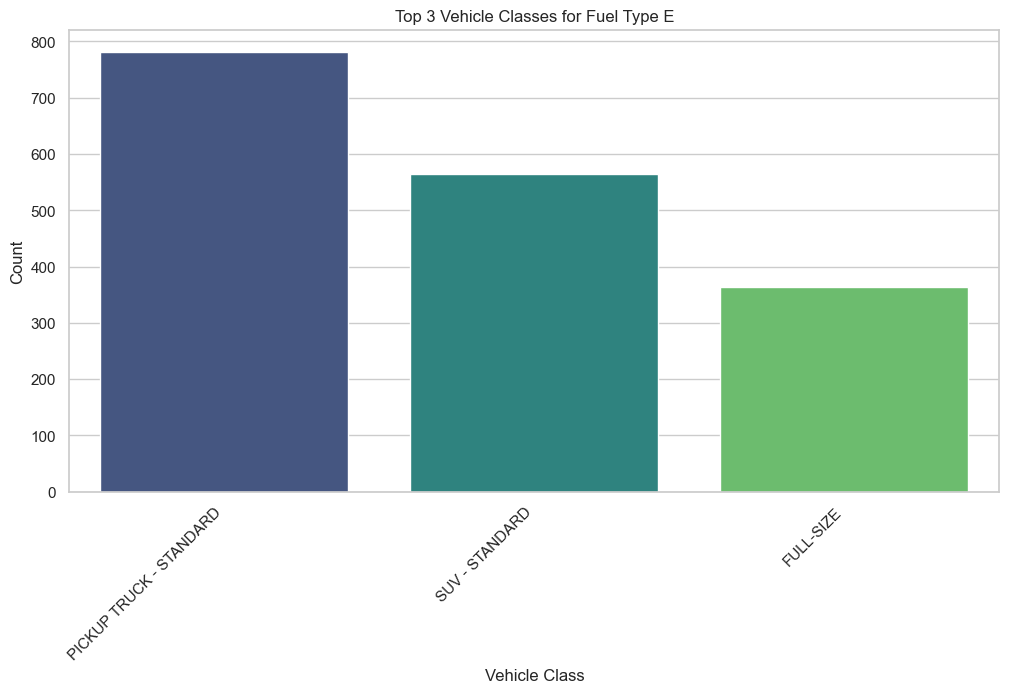

In [82]:
import seaborn as sns  # Importing seaborn for colormaps

E_fuel_df = train_df[train_df['Fuel Type'] == 'E']

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'Vehicle Class' is a categorical variable in your DataFrame
sns.set(style="whitegrid")  # Set the style of the plot

# Filter the top 10 vehicle classes
top_classes = E_fuel_df['Vehicle Class'].value_counts().nlargest(3)

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))  # Set the size of the plot
sns.barplot(x=top_classes.index, y=top_classes.values, palette="viridis")

# Add labels and title
plt.xlabel('Vehicle Class')
plt.ylabel('Count')
plt.title('Top 3 Vehicle Classes for Fuel Type E')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


In [42]:
train_df.columns

Index(['Make', 'Vehicle Class', 'Engine Size(L)', 'Cylinders', 'Transmission',
       'Fuel Type', 'Fuel Consumption City', 'Fuel Consumption Hwy',
       'Fuel Consumption Comb', 'CO2 Emissions(g/km)'],
      dtype='object')

In [49]:
import plotly.express as px

# Assuming 'CO2' is the column name in your DataFrame
fig = px.scatter(train_df, x="Engine Size(L)", y="Cylinders", color="CO2 Emissions(g/km)",
                 title='Cylinders vs Engine Size with CO2 Intensity',
                 labels={"Engine Size(L)": "Engine Size (L)", "Cylinders": "Cylinders"},
                 color_continuous_scale='Viridis',  # You can choose other color scales
                 color_continuous_midpoint=train_df['CO2 Emissions(g/km)'].mean())

# Find the row with the highest CO2 Emissions(g/km) value
highest_emission_row = train_df[train_df['Make'] == "LAMBOGI"]
for index, row in highest_emission_row.iterrows():
    # Create a separate scatter plot for the highest data point with a red marker
    fig.add_scatter(x=[row["Engine Size(L)"]],
                    y=[row["Cylinders"]],
                    marker=dict(color="red", size=10),
                    mode="markers",
                    name="Highest CO2 Emission",
                    showlegend=False)

# Update legend properties
fig.update_layout(legend=dict(title=dict(text="Legend Title"), traceorder='normal'))

fig.show()


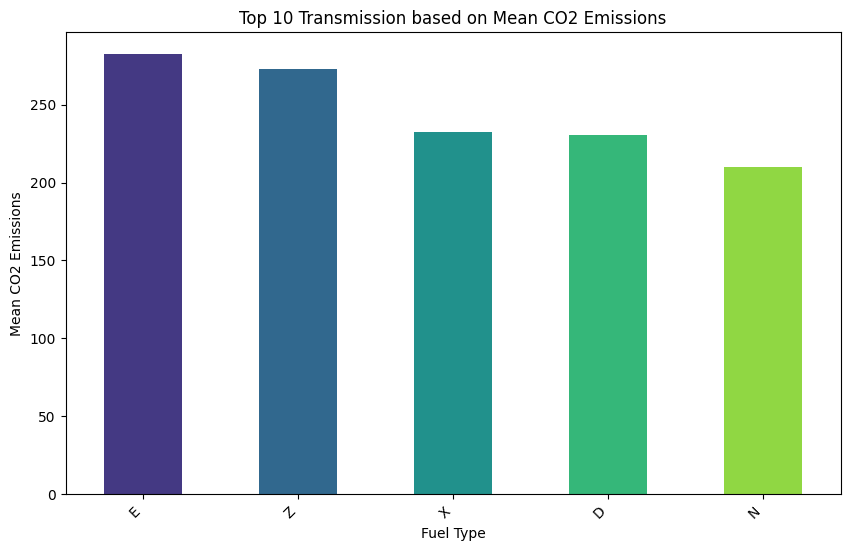

In [51]:
import seaborn as sns  # Importing seaborn for colormaps

# Assuming df is your DataFrame
top_make_by_co2 = train_df.groupby('Fuel Type')['CO2 Emissions(g/km)'].mean().sort_values(ascending=False).head(10)

# Plotting the top 10 'Fuel Type' values based on mean 'CO2' emissions with a gradient color
plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", len(top_make_by_co2))  # Choose a colormap, e.g., "viridis"
top_make_by_co2.plot(kind='bar', color=colors)
plt.title('Top 10 Transmission based on Mean CO2 Emissions')
plt.xlabel('Fuel Type')
plt.ylabel('Mean CO2 Emissions')
plt.xticks(rotation=45, ha='right')
plt.show()


In [53]:
import pandas as pd

# Assuming 'CO2 Emissions(g/km)', 'Make', and 'Fuel Type' are column names in your DataFrame
# Replace 'your_dataframe' with the actual DataFrame variable name

# Step 1: Calculate total CO2 emissions for each car make
total_emissions_by_make = train_df.groupby('Make')['CO2 Emissions(g/km)'].sum()

# Step 2: Identify the top 5 car makes with the highest total CO2 emissions
top_5_makes = total_emissions_by_make.nlargest(5).index

# Step 3: Determine the most common fuel type for each of the top 5 car makes
most_common_fuel_types = {}
for make in top_5_makes:
    make_data = train_df[train_df['Make'] == make]
    most_common_fuel_type = make_data['Fuel Type'].mode().values[0]
    most_common_fuel_types[make] = most_common_fuel_type

# Print the results
for make, fuel_type in most_common_fuel_types.items():
    print(f"{make}: {fuel_type}")

FOLD: X
CHEVO: X
BMV: Z
TOYOTI: X
DOGE: X


In [61]:
lambogi_fuel_df = train_df.loc[train_df['Make'] == 'LAMBOGI']
lambogi_fuel_df.isnull().sum()

Make                      0
Vehicle Class            19
Engine Size(L)           41
Cylinders                40
Transmission             14
Fuel Type                16
Fuel Consumption City    18
Fuel Consumption Hwy     18
Fuel Consumption Comb    22
CO2 Emissions(g/km)       0
dtype: int64

In [62]:
lambogi_fuel_df.head()

Make Vehicle Class  Engine Size(L)  Cylinders Transmission Fuel Type  \
63   LAMBOGI    TWO-SEATER             5.2       10.0          AM7         Z   
115  LAMBOGI    TWO-SEATER             6.5       12.0          AM7         Z   
128  LAMBOGI           NaN             4.0        8.0          AS8         Z   
138  LAMBOGI    TWO-SEATER             5.2       10.0          AM7         Z   
208  LAMBOGI    TWO-SEATER             5.2       10.0          AM7         Z   

     Fuel Consumption City  Fuel Consumption Hwy  Fuel Consumption Comb  \
63                4.219469              5.920000               4.840000   
115               4.761905              6.993007               5.561735   
128               5.649718              8.473639               6.650000   
138               6.211180              6.540000               6.353240   
208               5.680000              9.174312                    NaN   

     CO2 Emissions(g/km)  
63                   371  
115                  358  
128                  391  
138                  360  
208                  369

In [60]:
lambogi_fuel_df.dropna().value_counts()

Make     Fuel Type
LAMBOGI  Z            462
dtype: int64

Brand Lambogi memiliki mobil yang rata-rata emisinya tinggi.

In [79]:
import plotly.express as px

# Assuming 'CO2' is the column name in your DataFrame
fig = px.scatter(ready_df, x="Engine Size(L)", y="Cylinders", color="CO2 Emissions(g/km)",
                 title='Cylinders vs Engine Size with CO2 Intensity',
                 labels={"Engine Size(L)": "Engine Size (L)", "Cylinders": "Cylinders"},
                 color_continuous_scale='Viridis',  # You can choose other color scales
                 color_continuous_midpoint=ready_df['CO2 Emissions(g/km)'].mean())

# Find the row with the highest CO2 Emissions(g/km) value
highest_emission_row = ready_df[ready_df['Make'] == "LAMBOGI"]
for index, row in highest_emission_row.iterrows():
    # Create a separate scatter plot for the highest data point with a red marker
    fig.add_scatter(x=[row["Engine Size(L)"]],
                    y=[row["Cylinders"]],
                    marker=dict(color="red", size=10),
                    mode="markers",
                    name="Highest CO2 Emission")

fig.show()

Dapat terlihat bahwa Engin Size dan Cylinders mempunyai korelasi yang kuat. Semakin besar Engine Size, semakin besar Cylinders
Brand LAMBOGI yang mempunyai rata-rata emisi besar, dapat terlihat Engine Size dan Cylindernya juga besar. Hal ini menandakan bahwa Engine Size dan Cylinders punya pengaruh ke emisi

## Something Weird ?

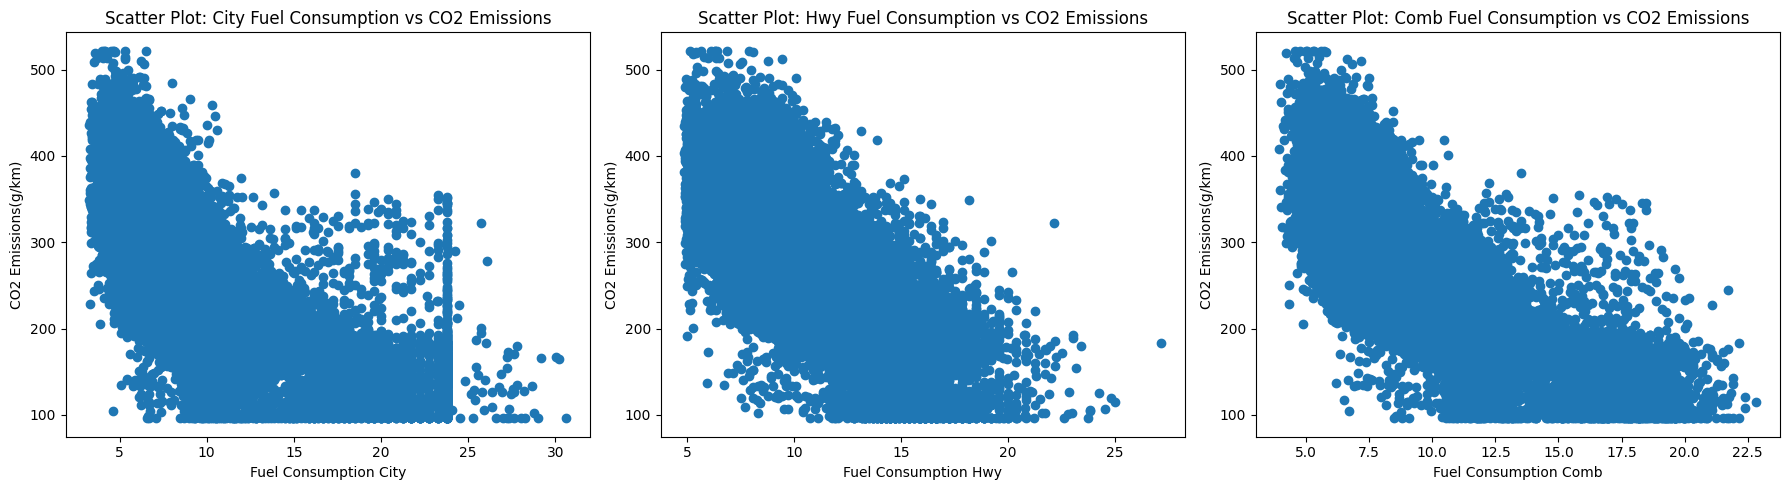

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a 1x3 subplot for side-by-side scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter plot 1
axes[0].scatter(ready_df['Fuel Consumption City'], ready_df['CO2 Emissions(g/km)'])
axes[0].set_xlabel('Fuel Consumption City')
axes[0].set_ylabel('CO2 Emissions(g/km)')
axes[0].set_title('Scatter Plot: City Fuel Consumption vs CO2 Emissions')

# Scatter plot 2
axes[1].scatter(ready_df['Fuel Consumption Hwy'], ready_df['CO2 Emissions(g/km)'])
axes[1].set_xlabel('Fuel Consumption Hwy')
axes[1].set_ylabel('CO2 Emissions(g/km)')
axes[1].set_title('Scatter Plot: Hwy Fuel Consumption vs CO2 Emissions')

# Scatter plot 3
axes[2].scatter(ready_df['Fuel Consumption Comb'], ready_df['CO2 Emissions(g/km)'])
axes[2].set_xlabel('Fuel Consumption Comb')
axes[2].set_ylabel('CO2 Emissions(g/km)')
axes[2].set_title('Scatter Plot: Comb Fuel Consumption vs CO2 Emissions')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

Pada Fuel Consumption City dapat terlihat banyak noise, sehingga kami coba untuk menjadikannya null value terlebih dahulu, agar nanti dapat di impute dan menghasilkan persebaran data yang lebih optimal

In [93]:
ready_df.loc[ready_df['Fuel Consumption City'] > 21, 'Fuel Consumption City'] = np.nan
test_df.loc[test_df['Fuel Consumption City'] > 21, 'Fuel Consumption City'] = np.nan

## Encoding Categorical Feature

we are using ordinal encoder and encoding them with the mean order of 'CO2 Emissions(g/km)' for each category. Encoding dengan urutan yang sesuai dapat membantu meningkatkan performa model

In [94]:
from sklearn.preprocessing import OrdinalEncoder
# Possible to rearrange
make_group = ready_df.groupby(by='Make')['CO2 Emissions(g/km)'].mean().sort_values(ascending=True).index.tolist()
vc_group = [np.nan] + ready_df.groupby(by='Vehicle Class')['CO2 Emissions(g/km)'].mean().sort_values(ascending=True).index.tolist()
trans_group = [np.nan] + ready_df.groupby(by='Transmission')['CO2 Emissions(g/km)'].mean().sort_values(ascending=True).index.tolist()
fuel_group = [np.nan] + ready_df.groupby(by='Fuel Type')['CO2 Emissions(g/km)'].mean().sort_values(ascending=True).index.tolist()

column_to_encode = ['Make','Vehicle Class','Transmission','Fuel Type']

enc = OrdinalEncoder(categories=[make_group, vc_group, trans_group, fuel_group])
ready_df[column_to_encode] = enc.fit_transform(ready_df[column_to_encode])
test_df[column_to_encode] = enc.transform(test_df[column_to_encode])
# ready_test_df[column_to_encode] = enc.transform(ready_test_df[column_to_encode])

In [95]:
# Replace 0 with np.nan in 'Vehicle Class', 'Transmission', 'Fuel Type'
cols_to_replace_nan = ['Vehicle Class', 'Transmission', 'Fuel Type']
ready_df[cols_to_replace_nan] = ready_df[cols_to_replace_nan].replace(0, np.nan)
test_df[cols_to_replace_nan] = test_df[cols_to_replace_nan].replace(0, np.nan)

for kols in cols_to_replace_nan:
    ready_df[kols] -= 1
    test_df[kols] -= 1

## Imput missing value using K Nearest Neighbor

In [96]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer

# Assuming ready_df is your original DataFrame with missing values

# Exclude columns related to "C02 Emission" from the imputation process
columns_to_exclude = ['CO2 Emissions(g/km)']  # Add the actual column names you want to exclude

# Create a KNNImputer with 5 neighbors
imputer = KNNImputer(n_neighbors=5)

# Filter the columns to exclude from the imputation
columns_for_imputation = [col for col in ready_df.columns if col not in columns_to_exclude]

# Fit and transform the DataFrame
ready_df_imputed = ready_df.copy()
ready_df_imputed[columns_for_imputation] = imputer.fit_transform(ready_df[columns_for_imputation])

# Convert the NumPy array back to a pandas DataFrame with the original column names
ready_df_imputed = pd.DataFrame(ready_df_imputed, columns=ready_df.columns)

# Now ready_df_imputed contains the imputed values with the same column names, excluding "C02 Emission" columns

# Apply the same transformation to the test_df
test_df_imputed = test_df.copy()
test_df_imputed[columns_for_imputation] = imputer.transform(test_df[columns_for_imputation])

# Convert the NumPy array back to a pandas DataFrame with the original column names
test_df_imputed = pd.DataFrame(test_df_imputed, columns=test_df.columns)

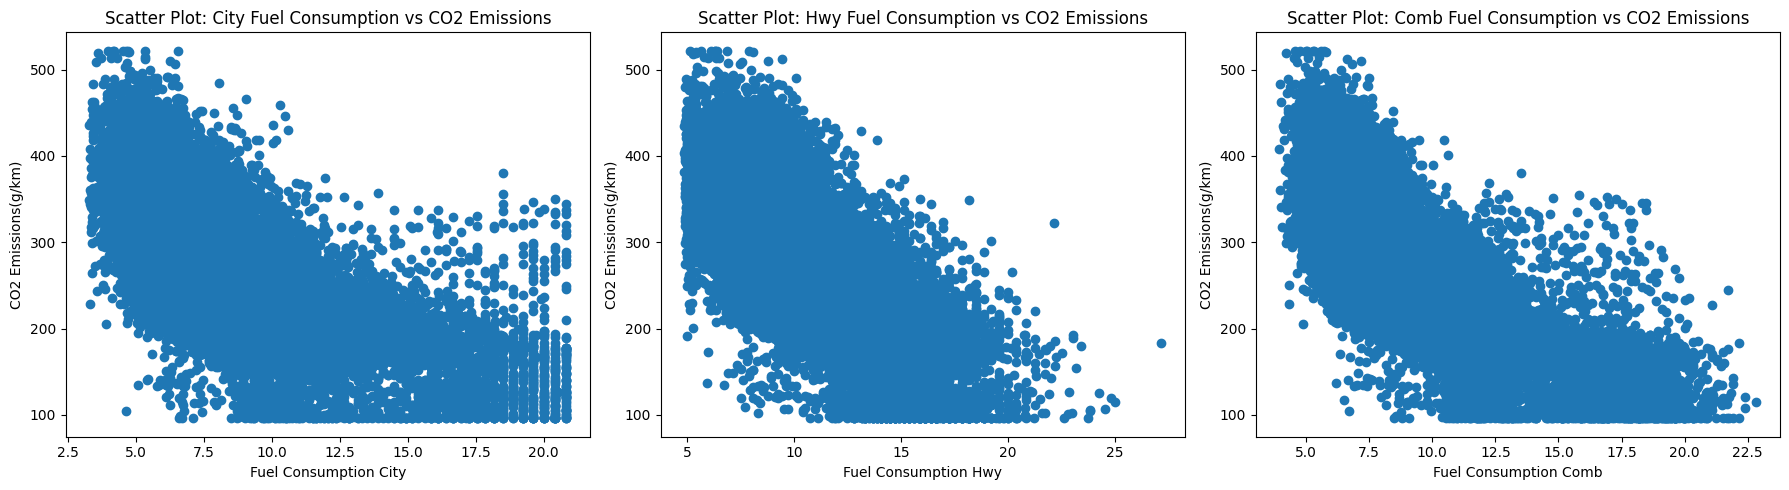

In [97]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a 1x3 subplot for side-by-side scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter plot 1
axes[0].scatter(ready_df['Fuel Consumption City'], ready_df['CO2 Emissions(g/km)'])
axes[0].set_xlabel('Fuel Consumption City')
axes[0].set_ylabel('CO2 Emissions(g/km)')
axes[0].set_title('Scatter Plot: City Fuel Consumption vs CO2 Emissions')

# Scatter plot 2
axes[1].scatter(ready_df['Fuel Consumption Hwy'], ready_df['CO2 Emissions(g/km)'])
axes[1].set_xlabel('Fuel Consumption Hwy')
axes[1].set_ylabel('CO2 Emissions(g/km)')
axes[1].set_title('Scatter Plot: Hwy Fuel Consumption vs CO2 Emissions')

# Scatter plot 3
axes[2].scatter(ready_df['Fuel Consumption Comb'], ready_df['CO2 Emissions(g/km)'])
axes[2].set_xlabel('Fuel Consumption Comb')
axes[2].set_ylabel('CO2 Emissions(g/km)')
axes[2].set_title('Scatter Plot: Comb Fuel Consumption vs CO2 Emissions')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [98]:
def create_feature(df_real):
  df = df_real.copy()
  return df

ready_df = create_feature(ready_df_imputed)

In [99]:
ready_df = pd.get_dummies(ready_df, columns=['Make'], prefix='Make')
test_df = pd.get_dummies(test_df_imputed, columns=['Make'], prefix='Make')

In [322]:
ready_df

Make  Vehicle Class  Engine Size(L)  Cylinders  Transmission   
0       3.0            6.0            1.50        4.0           7.0  \
1       9.0           17.0            4.00        6.0          22.0   
2       1.0            2.0            2.00        4.0          10.0   
3      16.0           21.0            5.34        8.0          15.0   
4       9.0            2.0            1.80        4.0           9.0   
...     ...            ...             ...        ...           ...   
54932  16.0           15.0            6.20        8.0          18.0   
54933  16.0           15.0            3.60        6.0           9.0   
54934  15.0           18.0            3.50        6.0          21.0   
54935  16.0           20.0            6.20        8.0          19.0   
54936   5.0           12.0            2.40        4.0          10.0   

       Fuel Type  Fuel Consumption City  Fuel Consumption Hwy   
0            2.0               8.400000             13.888889  \
1            2.0               7.250000             10.309278   
2            2.0               9.800000             13.699115   
3            2.0               5.780347              8.547009   
4            2.0              12.345679             12.658407   
...          ...                    ...                   ...   
54932        3.0               8.403361             11.360000   
54933        2.0               4.761905              9.433962   
54934        3.0               5.494505              8.000000   
54935        3.0               5.464481             10.101010   
54936        2.0              10.309278             13.698980   

       Fuel Consumption Comb  CO2 Emissions(g/km)  
0                  10.204082                208.0  
1                   8.361204                325.0  
2                  11.242478                170.0  
3                   6.765900                362.0  
4                  12.484395                180.0  
...                      ...                  ...  
54932               9.519558                318.0  
54933               6.126701                303.0  
54934               6.397953                410.0  
54935               6.887052                466.0  
54936              11.834644                192.0  

[54937 rows x 10 columns]

In [100]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer, RobustScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
# Melakukan scaling data

scaler=StandardScaler()

# Memisahkan antara fitur dan target
y = ready_df['CO2 Emissions(g/km)']
X = ready_df.drop(['CO2 Emissions(g/km)'],axis=1)

# Scaling the features using StandardScaler
X = scaler.fit_transform(X)
X_test = scaler.transform(test_df)

poly = PolynomialFeatures(degree=2, include_bias=False)
X = poly.fit_transform(X)
X_test = poly.transform(X_test)
X.shape

(54937, 464)

In [103]:
import numpy as np
import pandas as pd

# Assuming X is your feature data as a numpy array
# Replace X with your actual data
# X = np.array([[1, 2], [3, 4], [5, 6]])  # Example 2D array for features

# Convert the NumPy array to a pandas DataFrame
X_df = pd.DataFrame(X_test, columns=list(range(X_test.shape[1])))

# Save the DataFrame to a CSV file
X_df.to_csv('Test_Beryllium_Cyanide.csv', index=False)

In [432]:
X_test.shape

(23545, 495)

In [299]:
ready_df.columns

Index(['Make', 'Vehicle Class', 'Engine Size(L)', 'Cylinders', 'Transmission',
       'Fuel Type', 'Fuel Consumption City', 'Fuel Consumption Hwy',
       'Fuel Consumption Comb', 'CO2 Emissions(g/km)'],
      dtype='object')

# Modelling

Model Mahchine Learning yang akan kami gunakan ada Catboost 

Parameter dibawah ini didapatkan dari tuning menggunakan pycaret

In [ ]:
# reg_setup = setup(data=ready_df, target="CO2 Emissions(g/km)", session_id=123)
# catboost = create_model('catboost')
# tuned_catboost = tune_model(catboost, optimize='RMSE')
# evaluate_model(tuned_catboost)
# tuned_catboost.get_all_params()

In [69]:
catboost_params = {
    'nan_mode': 'Min',
    'eval_metric': 'RMSE',
    'iterations': 1000,
    'sampling_frequency': 'PerTree',
    'leaf_estimation_method': 'Newton',
    'random_score_type': 'NormalWithModelSizeDecrease',
    'grow_policy': 'SymmetricTree',
    'penalties_coefficient': 1,
    'boosting_type': 'Plain',
    'model_shrink_mode': 'Constant',
    'feature_border_type': 'GreedyLogSum',
    'eval_fraction': 0,
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'rsm': 1,
    'boost_from_average': True,
    'model_size_reg': 0.5,
    'subsample': 0.800000011920929,
    'use_best_model': False,
    'random_seed': 123,
    'depth': 6,
    'posterior_sampling': False,
    'border_count': 254,
    'sparse_features_conflict_fraction': 0,
    'leaf_estimation_backtracking': 'AnyImprovement',
    'best_model_min_trees': 1,
    'model_shrink_rate': 0,
    'min_data_in_leaf': 1,
    'loss_function': 'RMSE',
    'learning_rate': 0.06814000010490417,
    'score_function': 'Cosine',
    'task_type': 'CPU',
    'leaf_estimation_iterations': 1,
    'bootstrap_type': 'MVS',
    'max_leaves': 64,
    'iterations':2500
}

In [1]:
crg = CatBoostRegressor(**catboost_params)
crg.fit(X, y)
reg_result = crg.predict(X_test)

NameError: name 'CatBoostClassifier' is not defined

In [46]:
import pickle
with open('Beryllium_Cyanide.pkl', 'wb') as f:
    pickle.dump(crg, f)

In [436]:
reg_result

array([334.75595212, 196.5552243 , 212.47201391, ..., 241.11464927,
       226.40155411, 329.93338993])

In [148]:
submission_df = pd.read_csv("./data/sample_submission2.csv")

In [149]:
submission_df['CO2 Emissions(g/km)'] = reg_result

In [150]:
submission_df.to_csv("submission baseline2.csv", index=False)

# Evaluasi

Evaluasi pada lokal kami menggunakan K FOLD cross validation untuk menghindari overfitting.

In [133]:
n_fold = 5
folds = KFold(n_splits=n_fold, random_state = 1002, shuffle=True)
splits = folds.split(X, y)
rmse_total = 0
X.shape
for count , (train_index, valid_index) in enumerate(splits):
  X_tr, X_val = X[train_index], X[valid_index]
  y_tr, y_val = y.iloc[train_index], y.iloc[valid_index]
  crg = CatBoostRegressor(**catboost_params)
  crg.fit(X_tr, y_tr)
  reg_result = crg.predict(X_val)
  reg_result = [0 if x < 0 else x for x in reg_result]
  rmse = np.sqrt(mean_squared_error(y_val, reg_result))
  rmse_total += rmse
  print(rmse)


# Final Result
print(f"Reals RMSE {rmse_total/5}")

0:	learn: 64.1185275	total: 31.2ms	remaining: 31.2s
1:	learn: 60.7876234	total: 61.1ms	remaining: 30.5s
2:	learn: 57.6930595	total: 91.7ms	remaining: 30.5s
3:	learn: 54.8043430	total: 126ms	remaining: 31.3s
4:	learn: 52.1508596	total: 160ms	remaining: 31.9s
5:	learn: 49.7589833	total: 197ms	remaining: 32.7s
6:	learn: 47.5833090	total: 234ms	remaining: 33.2s
7:	learn: 45.5578458	total: 274ms	remaining: 33.9s
8:	learn: 43.6606282	total: 308ms	remaining: 33.9s
9:	learn: 41.9567527	total: 346ms	remaining: 34.2s
10:	learn: 40.3877137	total: 388ms	remaining: 34.9s
11:	learn: 38.9519175	total: 429ms	remaining: 35.3s
12:	learn: 37.6228743	total: 468ms	remaining: 35.6s
13:	learn: 36.4384050	total: 504ms	remaining: 35.5s
14:	learn: 35.3278673	total: 542ms	remaining: 35.6s
15:	learn: 34.3315833	total: 578ms	remaining: 35.5s
16:	learn: 33.4092592	total: 614ms	remaining: 35.5s
17:	learn: 32.6110850	total: 649ms	remaining: 35.4s
18:	learn: 31.8918001	total: 683ms	remaining: 35.3s
19:	learn: 31.16031